In [1]:
# This is autoreload module code using jupyter magic
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np

from functools import partial

import gymnax
from mdps.wrappers import FlattenObservationWrapper, LogWrapper
from agents.basic import BasicAgent
from agents.linear_transformer import LinearTransformerAgent
from jax.random import split

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from ppo_general import make_train

from mdps.gridworld import GridEnv
from mdps.discrete_smdp import DiscreteInit, DiscreteTransition, DiscreteObs, DiscreteReward
from mdps.continuous_smdp import ContinuousInit, ContinuousMatrixTransition, ContinuousMatrixObs, ContinuousReward
import mdps.discrete_smdp
from mdps.syntheticmdp import SyntheticMDP
from mdps.wrappers_mine import TimeLimit, RandomlyProjectObservation, NoReward
import mdps.natural_mdps

import networkx as nx
import matplotlib.pyplot as plt

from train import *

In [3]:
envs = [
    # gymnax.environments.MountainCar(),
    # gymnax.environments.CartPole(),
    # gymnax.environments.Acrobot(),
    mdps.natural_mdps.MountainCar(),
    mdps.natural_mdps.CartPole(),
    mdps.natural_mdps.Acrobot(),
    GridEnv(8),
]

2023-11-14 17:33:33.744971: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


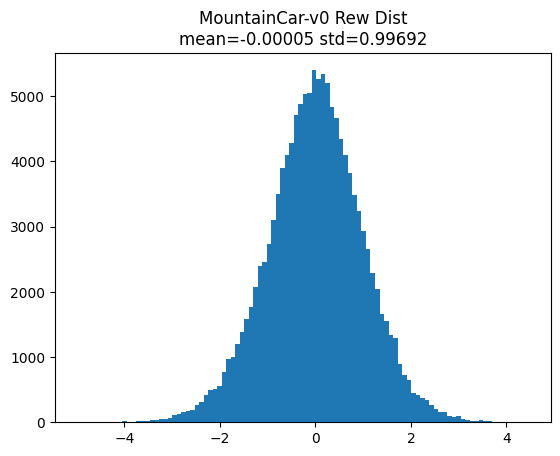

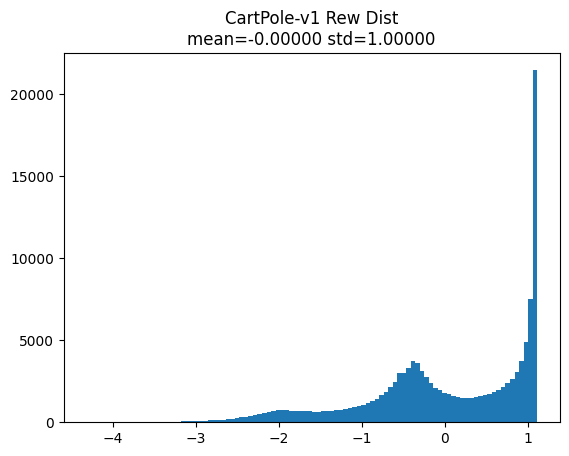

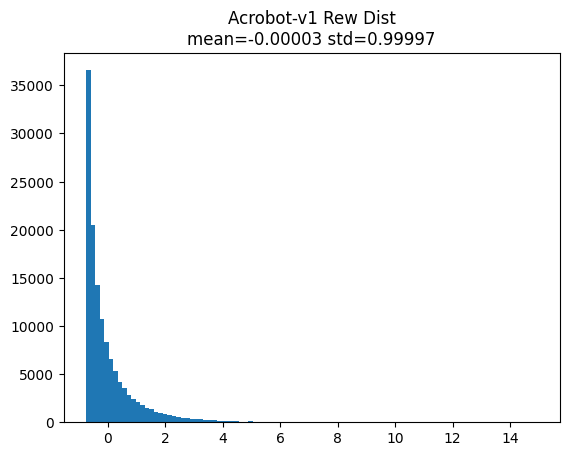

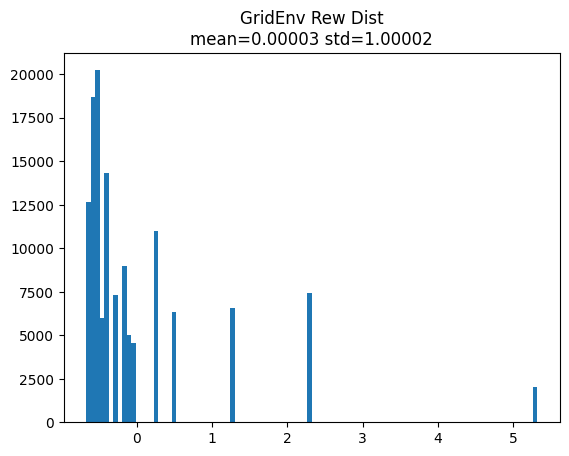

In [4]:
for env in envs:
    rng = jax.random.PRNGKey(0)

    rng, _rng = split(rng)
    env_params = jax.vmap(env.sample_params)(split(_rng, 1024))
    rng, _rng = split(rng)
    _, state = jax.vmap(env.reset)(split(_rng, 1024), env_params)

    rews = []
    for t in range(128):
        rng, _rng = split(rng)
        act = jax.random.randint(_rng, (1024,), 0, env.action_space(None).n)
        rng, _rng = split(rng)
        _, state, rew, _, _ = jax.vmap(env.step)(split(_rng, 1024), state, act, env_params)
        rews.append(rew)

    rews = jnp.stack(rews).flatten()

    plt.hist(np.asarray(rews), bins=100);
    plt.title(f"{env.name} Rew Dist\nmean={rews.mean():0.05f} std={rews.std():0.05f}");
    plt.show()



Array(0.25034866, dtype=float32)

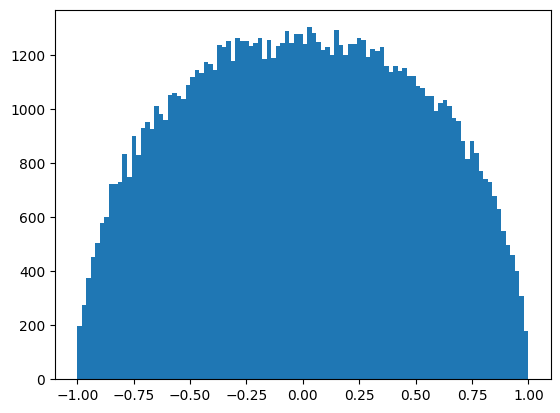

In [97]:
rng = jax.random.PRNGKey(0)
d = 2
a = jax.random.ball(rng, d, shape=(100000,))@jnp.eye(d, d)[0]
plt.hist(np.asarray(a), bins=100);
a.var()



In [16]:
ds = np.array([8, 16, 32, 64, 128, 256, 512])
vars = [(jax.random.ball(rng, d, shape=(10000,))@jnp.eye(d, d)[0]).var() for d in tqdm(ds)]

  0%|          | 0/7 [00:00<?, ?it/s]

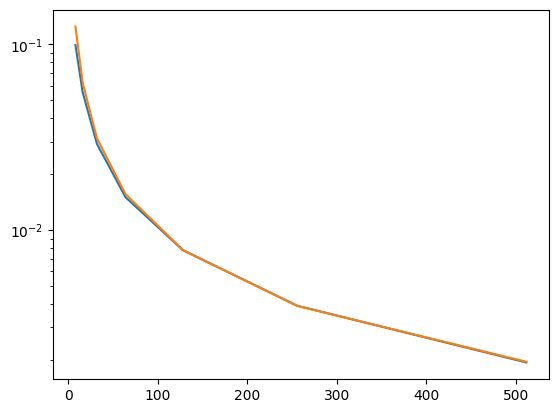

In [18]:
plt.plot(ds, vars)
plt.plot(ds, 1/ds)
plt.yscale('log')


In [5]:
for env in envs:
    print(env.name)
    print(env.action_space(None).n)

MountainCar-v0
3
CartPole-v1
2
Acrobot-v1
3
GridEnv
4


In [7]:
file = '/data/vision/phillipi/akumar01/synthetic-mdps/data/env=dsmdp;n_states=64;n_acts=4;d_obs=64;rdist=N;rpo=64;tl=4/config.pkl'

In [9]:
with open(file, 'rb') as f:
    config = pickle.load(f)

In [12]:
config['ENV']

'env=dsmdp;n_states=64;n_acts=4;d_obs=64;rdist=N;rpo=64;tl=4'